# <span style="color:#0b486b">  FIT3181: Deep Learning (2021)</span>
***
*CE/Lecturer:*  **Dr Trung Le** | trunglm@monash.edu <br/>
*Head TA:*  **Mr Thanh Nguyen** | thanh.nguyen4@monash.edu <br/>
*Tutor:* **Dr Van Nguyen**  \[van.nguyen1@monash.edu \] | **Mr James Tong** \[james.tong1@monash.edu\] | **Dr Mahmoud Mohammad** \[mahmoud.hossam@monash.edu\]
<br/> <br/>
Faculty of Information Technology, Monash University, Australia
***


# <span style="color:#0b486b">Tutorial 5b: Convolutional Neural Network with MiniVGG</span><span style="color:red;  font-size: 18px">***** (highly important)</span> #
**This tutorial applies CNN to a more real-world setting using TensorFlow using the `CIFAR-10` dataset. It will cover the following**:
1. ***How to implement a simplified version of a real-world CNN named `MiniVGG` to classify the `CIFAR-10` dataset using TF 2.x.***

VGGNet, (aka VGG), was first introduced by Simonyan and Zisserman in their 2014 paper, *Very Deep Learning Convolutional Neural Networks for Large-Scale Image Recognition*. 
The work was the first to demonstrate that architecture with very small (3×3) filters can be successfully trained for very deep networks (16-19 layers) and obtain state-of-the-art classification on the challenging ImageNet classification challenge. <br/>

The VGG family of Convolutional Neural Networks can be characterized by two key components:
1. *All CONV layers in the network using only **3×3** filters.*
2. *Stacking multiple CONV => RELU layer sets (where the number of consecutive CONV => RELU layers normally increases as we go deeper) before applying a POOL operation.* <br/>

Due to the size of this architecture which compromises the running time, this tutorial will use `MiniVGG` which is a simplified version of `VGG` including its architecture, implementation, and application to the `CIFAR-10` dataset.

---

## <span style="color:#0b486b">I. MiniVGG for the CIFAR-10 dataset</span> ##

### <span style="color:#0b486b">I.1. Architecture of MiniVGG </span>
The following figure and table show the concrete architecture of `MiniVGG`. As mentioned before, `MiniVGG` only uses $3\times3$ filters. In addition, in the `MiniVGGNet`, we apply the batch norm technique to regularize the training and allow the network to be trained with a higher learning rate.

<img src='images/MiniVGG_Table.png' align='center' width=300/>

### <span style="color:#0b486b">I.2. Implementation of MiniVGG </span>

#### <span style="color:#0b486b">I.2.1 Import necessary packages and modules </span>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, models, layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.random.seed(123)
tf.random.set_seed(123)

#### <span style="color:#0b486b">I.2.2 Download, prepare and preprocess CIFAR-10 dataset </span>

The CIFAR-10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [2]:
(X_train_full, y_train_full) , (X_test_full, y_test_full) = datasets.cifar10.load_data()
X_train_full, X_test_full = X_train_full/255.0, X_test_full/255.0
print(X_train_full.shape, y_train_full.shape)
print(X_test_full.shape, y_test_full.shape)

(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)


Shuffle the entire dataset.

In [3]:
train_val_idx = np.random.permutation(X_train_full.shape[0])
test_idx = np.random.permutation(X_test_full.shape[0])

Create a tiny `CIFAR-10` for a demonstration.

In [4]:
n_train, n_valid, n_test = 5000, 5000, 5000 
X_train, y_train = X_train_full[train_val_idx][:n_train], y_train_full[train_val_idx][:n_train]
X_valid, y_valid = X_train_full[train_val_idx][n_train:n_train+n_valid], y_train_full[train_val_idx][n_train:n_train+n_valid]
X_test, y_test = X_test_full[test_idx][:n_test], y_test_full[test_idx][:n_test]
y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)
y_test = y_test.reshape(-1)
print('Training set', X_train.shape, y_train.shape)
print('Validation set', X_valid.shape, y_valid.shape)
print('Test set', X_test.shape, y_test.shape)

Training set (5000, 32, 32, 3) (5000,)
Validation set (5000, 32, 32, 3) (5000,)
Test set (5000, 32, 32, 3) (5000,)


#### <span style="color:#0b486b">I.2.3 Visualize CIFAR-10 images </span>

In [5]:
import math
def visualize_data(images, categories, images_per_row = 8):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    n_images = len(images)
    n_rows = math.ceil(float(n_images)/images_per_row)
    fig = plt.figure(figsize=(1.5*images_per_row, 1.5*n_rows))
    fig.patch.set_facecolor('white')
    for i in range(n_images):
        plt.subplot(n_rows, images_per_row, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i]
        plt.xlabel(class_names[class_index])
    plt.show()

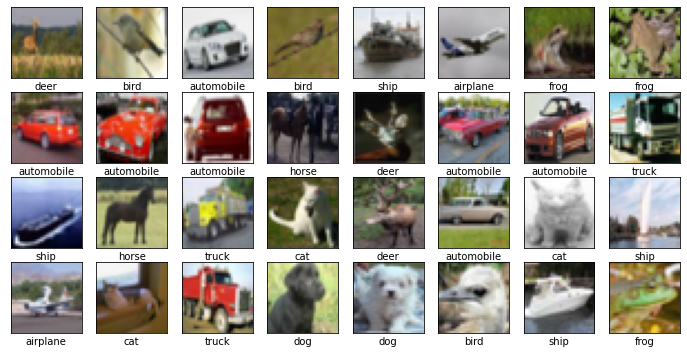

In [6]:
visualize_data(X_train[0:32], y_train[0:32])

#### <span style="color:#0b486b">I.2.4 Build up MiniVGG network </span>

In [7]:
def create_vgg():
    vgg_model = models.Sequential()
    vgg_model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.MaxPool2D(pool_size=(2,2)))  #downscale the image size by 2
    vgg_model.add(layers.Dropout(rate=0.25))  #deactivate 25% of neurons for each feed-forward
    vgg_model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.MaxPool2D(pool_size=(2,2)))  #downscale the image size by 2
    vgg_model.add(layers.Dropout(rate=0.25))  #deactivate 25% of neurons for each feed-forward
    vgg_model.add(layers.Flatten())
    vgg_model.add(layers.Dense(512, activation='relu'))
    vgg_model.add(layers.BatchNormalization(momentum=0.9))
    vgg_model.add(layers.Dropout(rate=0.5)) 
    vgg_model.add(layers.Dense(10, activation='softmax')) #ten classes in CIFAR-10
    return vgg_model

In [8]:
vgg = create_vgg()
vgg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

In [9]:
opt = keras.optimizers.Adam(learning_rate=0.001)
vgg.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
no_aug_history = vgg.fit(x=X_train, y=y_train, batch_size=32, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
157/157 [==============================] - 12s 71ms/step - loss: 2.3850 - accuracy: 0.3034 - val_loss: 2.1012 - val_accuracy: 0.3998
Epoch 2/30
157/157 [==============================] - 12s 74ms/step - loss: 1.8171 - accuracy: 0.4028 - val_loss: 1.6161 - val_accuracy: 0.4690
Epoch 3/30
157/157 [==============================] - 11s 72ms/step - loss: 1.4859 - accuracy: 0.4944 - val_loss: 1.6797 - val_accuracy: 0.4834
Epoch 4/30
157/157 [==============================] - 11s 73ms/step - loss: 1.3593 - accuracy: 0.5292 - val_loss: 1.3259 - val_accuracy: 0.5478
Epoch 5/30
157/157 [==============================] - 12s 75ms/step - loss: 1.1541 - accuracy: 0.5976 - val_loss: 1.6528 - val_accuracy: 0.4976
Epoch 6/30
157/157 [==============================] - 12s 74ms/step - loss: 1.0855 - accuracy: 0.6202 - val_loss: 1.2822 - val_accuracy: 0.5654
Epoch 7/30
157/157 [==============================] - 12s 75ms/step - loss: 0.9524 - accuracy: 0.6646 - val_loss: 1.2171 - val_accuracy:

We now can evaluate the performance on the CIFAR-10 test set.

In [10]:
test_loss, test_acc = vgg.evaluate(X_test,  y_test, verbose=1, batch_size=64)
print("Test acc is {}".format(test_acc))

79/79 [==============================] - 2s 23ms/step - loss: 1.5206 - accuracy: 0.6206
Test acc is 0.6205999851226807


### <span style="color:#0b486b">I.2.5 Plot training loss and accuracy</span> ###

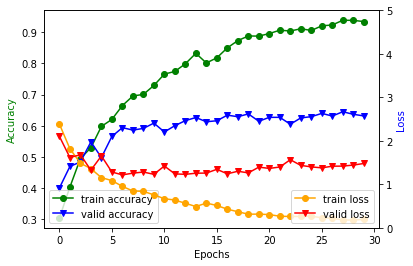

In [11]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(no_aug_history.history['accuracy'], label='train accuracy', color='green', marker="o")
ax1.plot(no_aug_history.history['val_accuracy'], label='valid accuracy', color='blue', marker = "v")
ax2.plot(no_aug_history.history['loss'], label = 'train loss', color='orange', marker="o")
ax2.plot(no_aug_history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
ax1.legend(loc=3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax2.legend(loc=4)
plt.ylim([0.0, 5])
plt.show()

## <span style="color:#0b486b">II. MiniVGG with data augmentation</span> ##

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

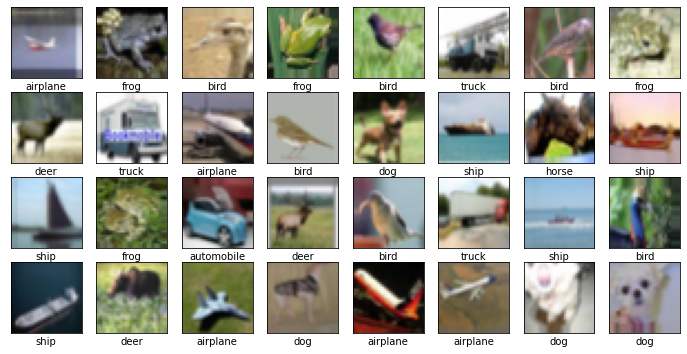

In [13]:
datagen = ImageDataGenerator(horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1)
datagen.fit(X_train)

it = datagen.flow(X_train, y_train, batch_size=32)
batch_images, batch_labels = next(it)

visualize_data(batch_images, batch_labels)

In [14]:
vgg = create_vgg()
opt = keras.optimizers.Adam(learning_rate=0.001)
vgg.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
steps = len(X_train) // 32
with_aug_history = vgg.fit(it, epochs=30, steps_per_epoch=steps, validation_data=(X_valid, y_valid))

Epoch 1/30
156/156 [==============================] - 12s 76ms/step - loss: 2.3717 - accuracy: 0.3007 - val_loss: 1.7003 - val_accuracy: 0.4288
Epoch 2/30
156/156 [==============================] - 12s 76ms/step - loss: 1.9026 - accuracy: 0.3845 - val_loss: 1.4827 - val_accuracy: 0.4798
Epoch 3/30
156/156 [==============================] - 12s 75ms/step - loss: 1.7191 - accuracy: 0.4140 - val_loss: 1.4428 - val_accuracy: 0.5032
Epoch 4/30
156/156 [==============================] - 12s 75ms/step - loss: 1.5963 - accuracy: 0.4448 - val_loss: 1.4087 - val_accuracy: 0.5114
Epoch 5/30
156/156 [==============================] - 12s 76ms/step - loss: 1.4997 - accuracy: 0.4658 - val_loss: 1.3361 - val_accuracy: 0.5254
Epoch 6/30
156/156 [==============================] - 12s 78ms/step - loss: 1.4085 - accuracy: 0.5044 - val_loss: 1.3370 - val_accuracy: 0.5376
Epoch 7/30
156/156 [==============================] - 12s 78ms/step - loss: 1.3400 - accuracy: 0.5405 - val_loss: 1.3059 - val_accuracy:

In [15]:
test_loss, test_acc = vgg.evaluate(X_test,  y_test, verbose=1, batch_size=64)
print("Test acc is {}".format(test_acc))

79/79 [==============================] - 2s 24ms/step - loss: 0.9930 - accuracy: 0.6714
Test acc is 0.6714000105857849


We can observe an improvement when evaluating on the testing set.

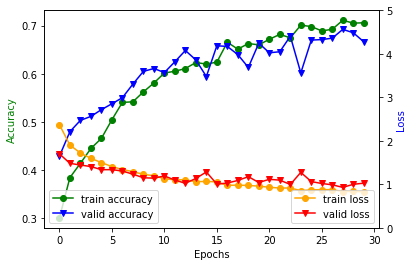

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(with_aug_history.history['accuracy'], label='train accuracy', color='green', marker="o")
ax1.plot(with_aug_history.history['val_accuracy'], label='valid accuracy', color='blue', marker = "v")
ax2.plot(with_aug_history.history['loss'], label = 'train loss', color='orange', marker="o")
ax2.plot(with_aug_history.history['val_loss'], label = 'valid loss', color='red', marker = "v")
ax1.legend(loc=3)

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax2.legend(loc=4)
plt.ylim([0.0, 5])
plt.show()

## <span style="color:#0b486b">III. Visualize filters of MiniVGG</span> ##

Visualizing the filters and feature maps is important to help us understand what is learned by trained CNNs. We expect that low layers can capture low-level features such as edges, pixels, and corners, middle layers can capture mid-level features such as circles, boxes, triangles, while high layers can capture high-level features such as objects. According to the operational principle of CNNs, features captured by higher layers are a combination of those in lower layers. For example, edges combine into boxes, and boxes and triangles, in turn, combine into more complicated objects.

We now explore how to visualize the filters and feature maps for our trained MiniVGG network.

We first play around with how to get all layers in a TF keras model and how to extract information from a specific layer.

In [17]:
for i, layer in enumerate(vgg.layers):
    print("Layer {}: {}".format(i, layer.name))

Layer 0: conv2d_4
Layer 1: batch_normalization_5
Layer 2: conv2d_5
Layer 3: batch_normalization_6
Layer 4: max_pooling2d_2
Layer 5: dropout_3
Layer 6: conv2d_6
Layer 7: batch_normalization_7
Layer 8: conv2d_7
Layer 9: batch_normalization_8
Layer 10: max_pooling2d_3
Layer 11: dropout_4
Layer 12: flatten_1
Layer 13: dense_2
Layer 14: batch_normalization_9
Layer 15: dropout_5
Layer 16: dense_3


In what follows, we examine all Conv2D layers in our network and print out their filters. Recall that the set of filters is represented as a $4D$ tensor with the shape $[fil\_height, fil\_width, fil\_depth, num\_filters]$.

In [18]:
for layer in vgg.layers:
    if isinstance(layer, tf.keras.layers.Conv2D):
        print("Layer name: {}, shape: [{}, {}]".format(layer.name, layer.filters, layer.kernel_size))
        print(layer.get_weights()[0].shape)

Layer name: conv2d_4, shape: [32, (3, 3)]
(3, 3, 3, 32)
Layer name: conv2d_5, shape: [32, (3, 3)]
(3, 3, 32, 32)
Layer name: conv2d_6, shape: [64, (3, 3)]
(3, 3, 32, 64)
Layer name: conv2d_7, shape: [64, (3, 3)]
(3, 3, 64, 64)


We now visualize a filter in a Conv2D layer of a specific model. Note that each filter is a 3D tensor with shape $[fil\_height, fil\_width, fil\_depth]$.

In [19]:
import math
from IPython.display import clear_output

def visualize_filter(model, layer_name= None, filter_index=1, n_cols = 8):
    plt.pause(0.25)
    layer = model.get_layer(layer_name)
    assert isinstance(layer, tf.keras.layers.Conv2D), "The current layer is not a Conv2D layer"
    filters = layer.get_weights()[0]  #4D tensor of all filters
    assert filter_index <= filters.shape[-1], "The filter index is out of range"
    one_filter = filters[:,:,:, filter_index-1]  #the filter we need to visualize
    fil_depth = one_filter.shape[-1]
    n_rows = math.ceil(fil_depth/n_cols)
    fig = plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
    plt.axis("off")
    for i in range(fil_depth):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(one_filter[:,:,i], cmap="gray")
        plt.xlabel("{} of {}".format(i, filter_index))
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

We visualize the 5th filter in the filters of the convolutional layer conv2d_5 (Layer 2)


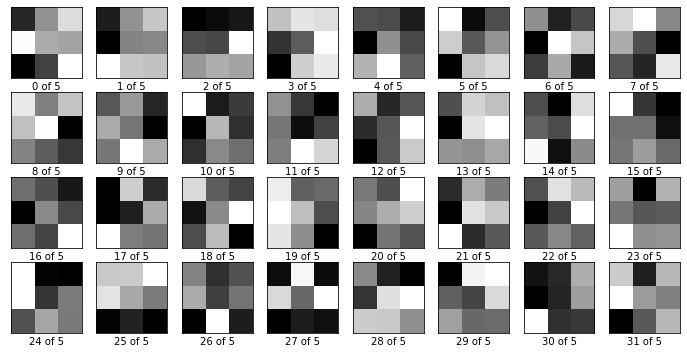

In [20]:
print("We visualize the 5th filter in the filters of the convolutional layer {} (Layer 2)".format(vgg.layers[2].name))
visualize_filter(vgg, vgg.layers[2].name, filter_index=5)

We visualize the 5th filter in the filters of the convolutional layer conv2d_6 (Layer 6)


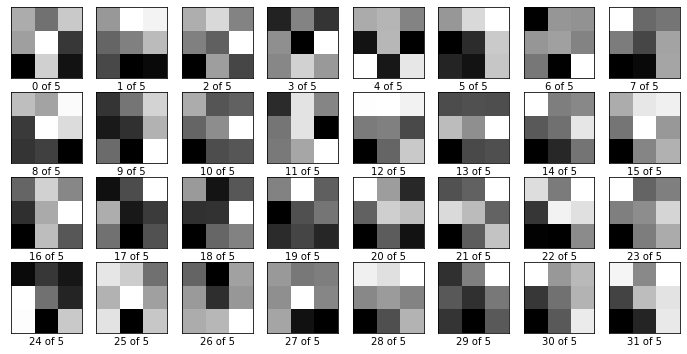

In [21]:
print("We visualize the 5th filter in the filters of the convolutional layer {} (Layer 6)".format(vgg.layers[6].name))
visualize_filter(vgg, vgg.layers[6].name, filter_index=5)

 **<span style="color:red">Exercise 1</span>:** Expand the function `visualize_filter` so that if `filter_index=None`, we visualize all filters of the layer.

In [22]:
def visualize_filter_all(model, layer_name=None, n_cols=8):
    layer = model.get_layer(layer_name)
    assert isinstance(layer, tf.keras.layers.Conv2D), "The current layer is not a Conv2D layer"
    filters = layer.get_weights()[0]  # 4D tensor of all filters
    for filter_index in range(filters.shape[-1]):
        visualize_filter(model, layer_name, filter_index, n_cols=8)

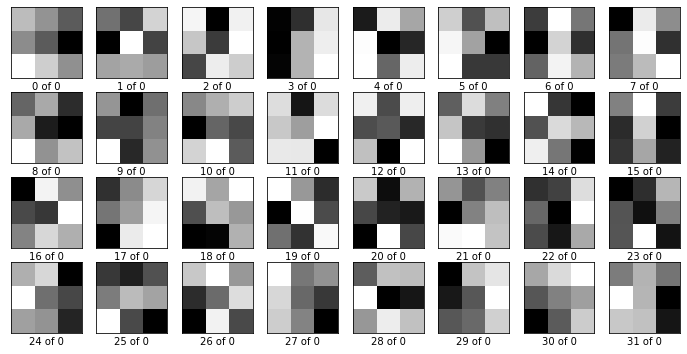

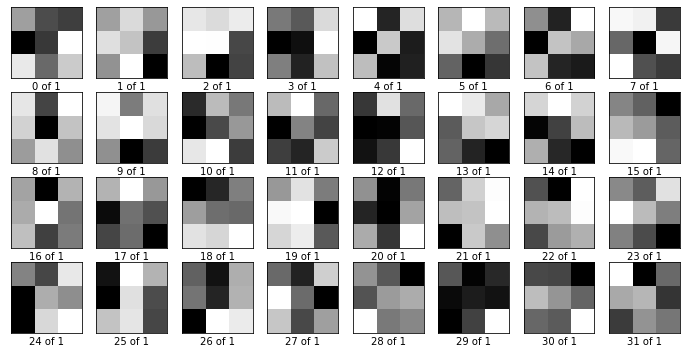

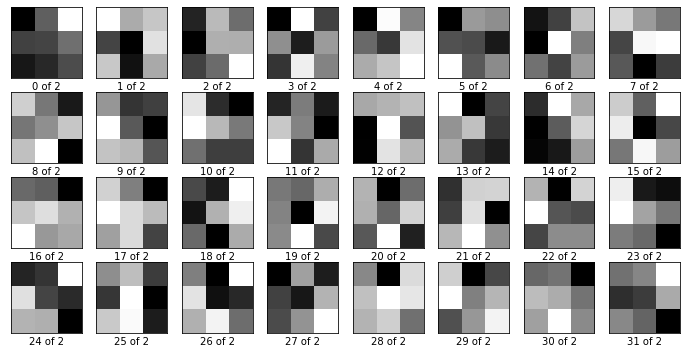

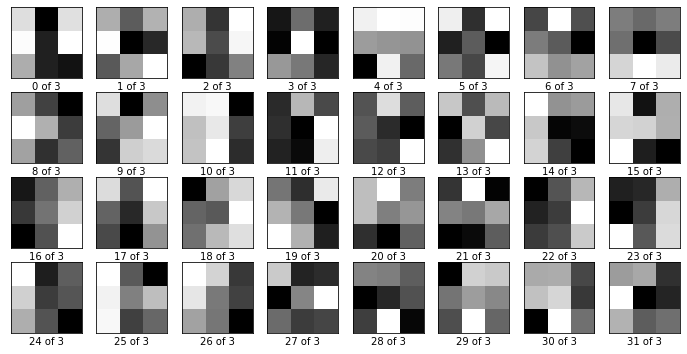

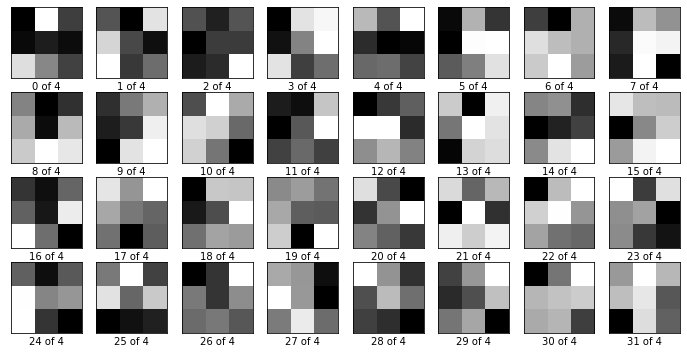

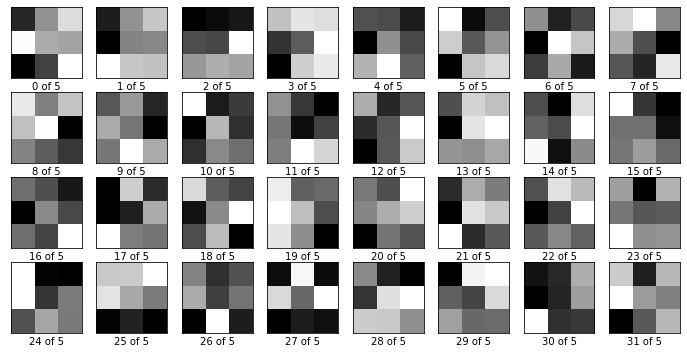

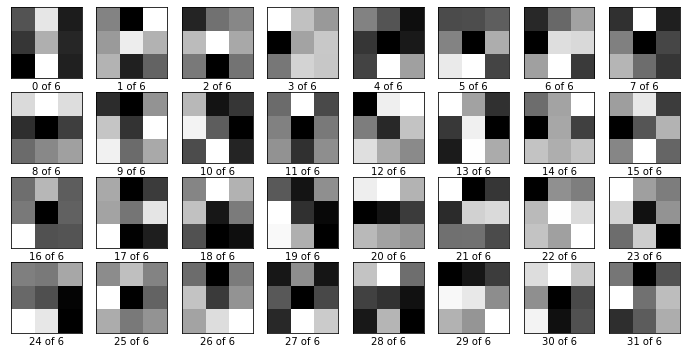

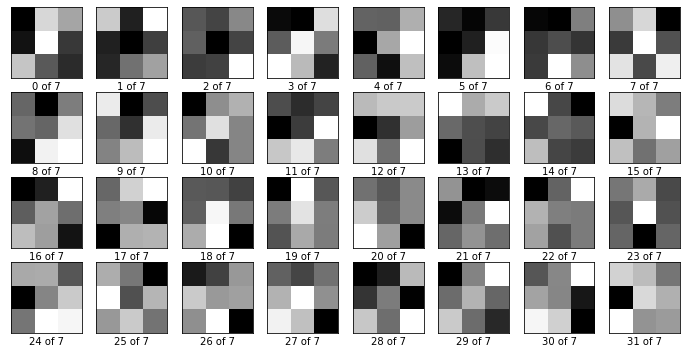

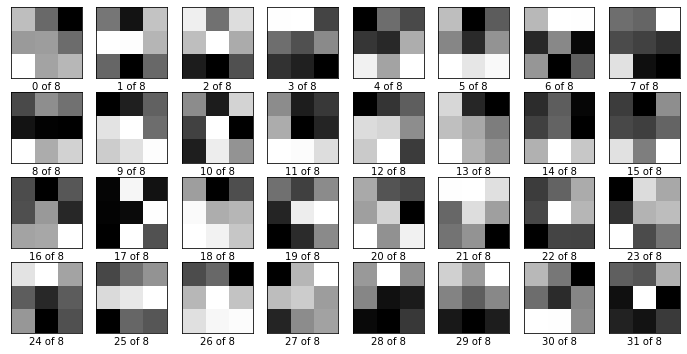

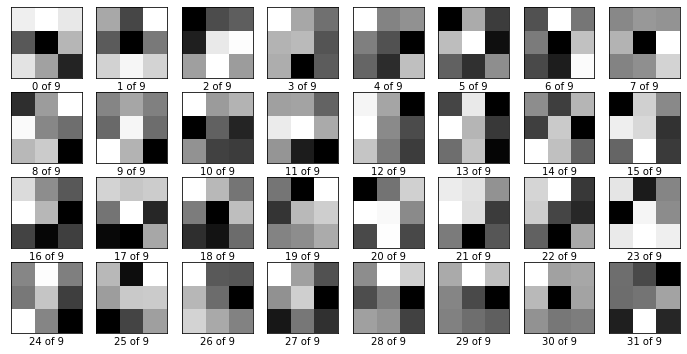

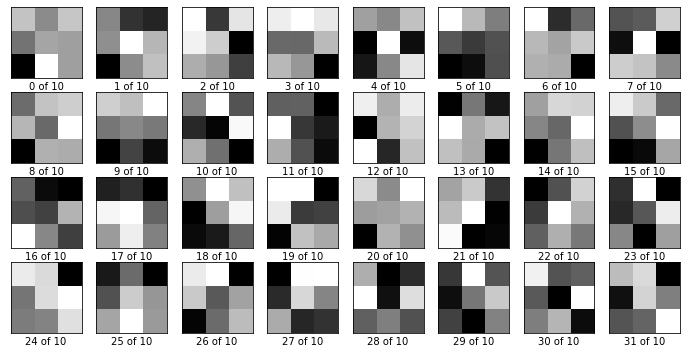

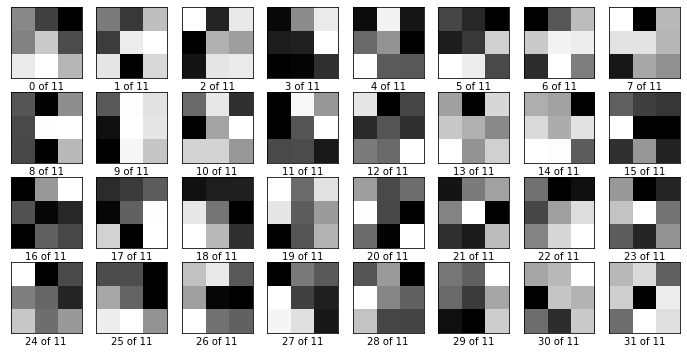

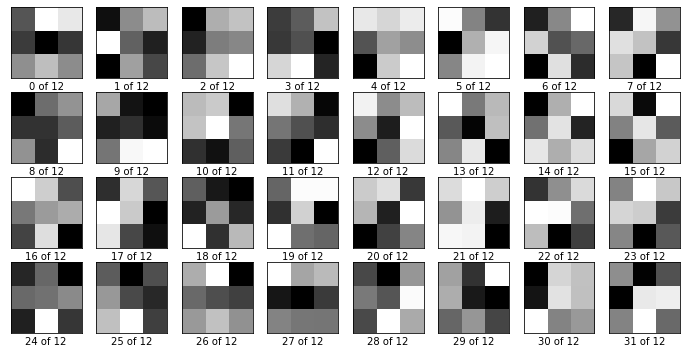

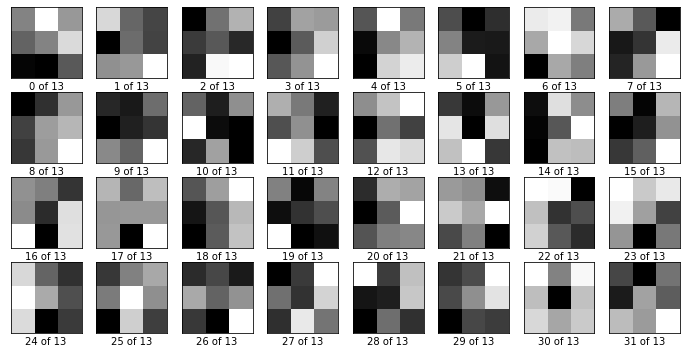

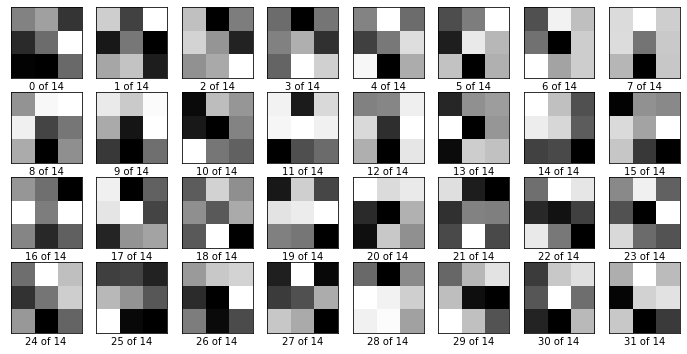

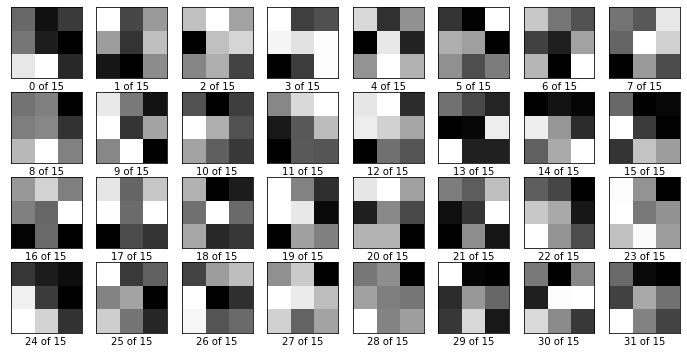

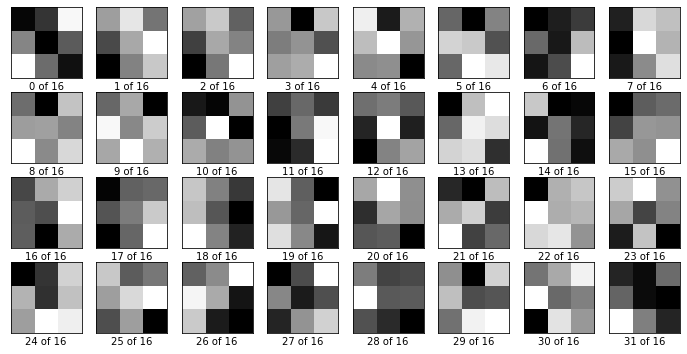

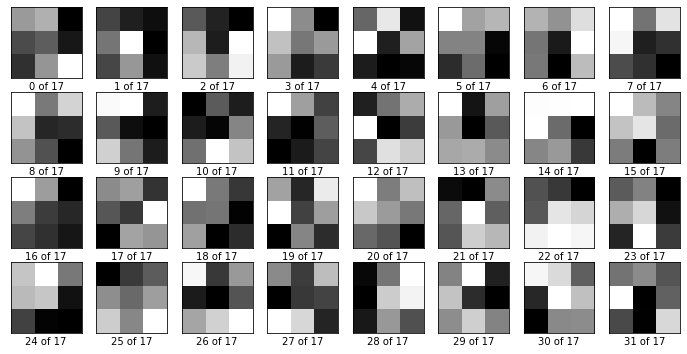

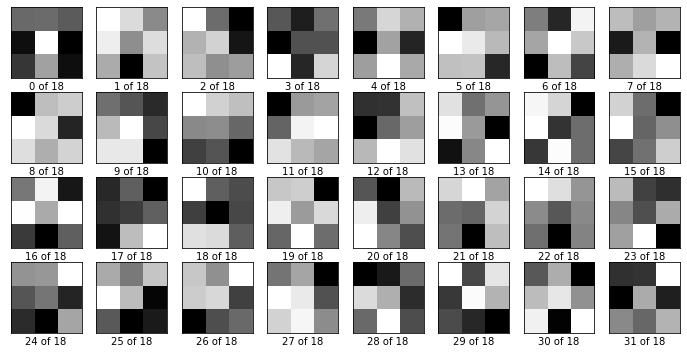

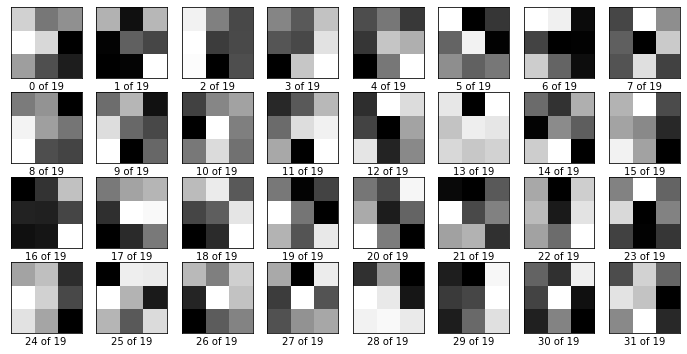

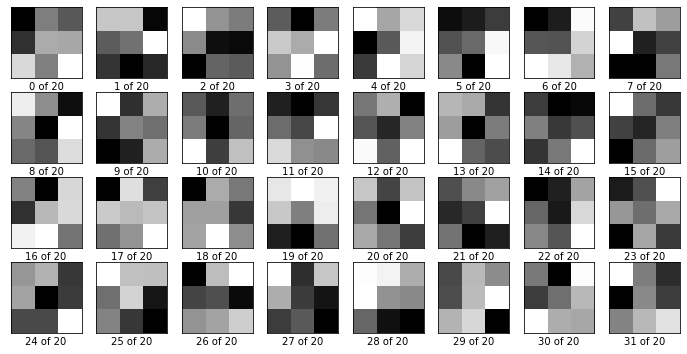

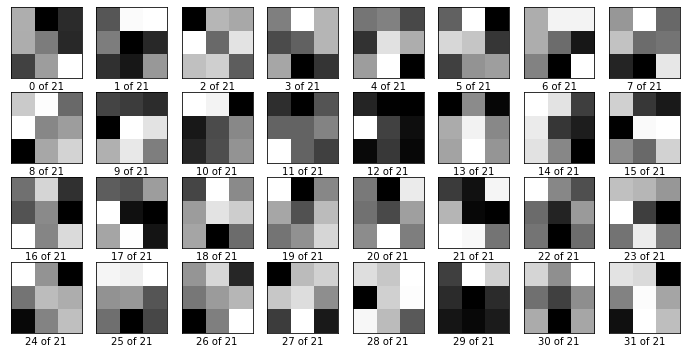

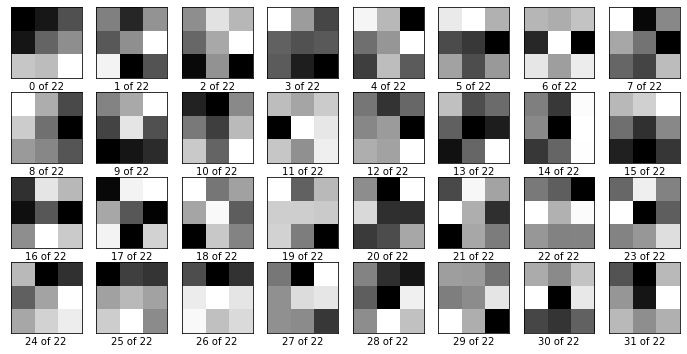

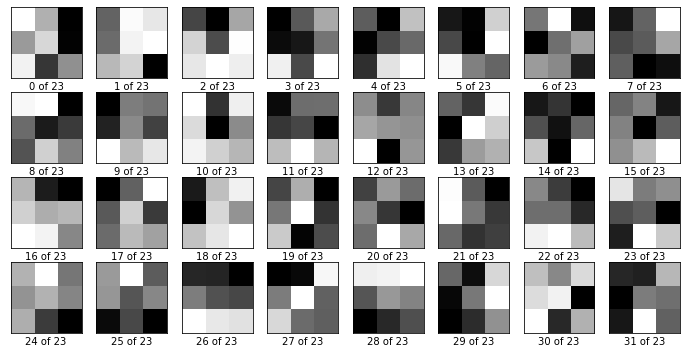

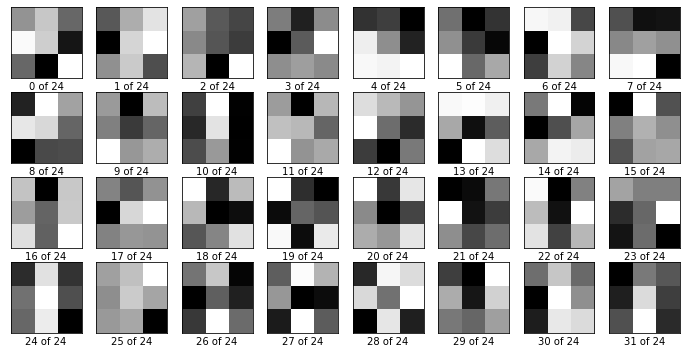

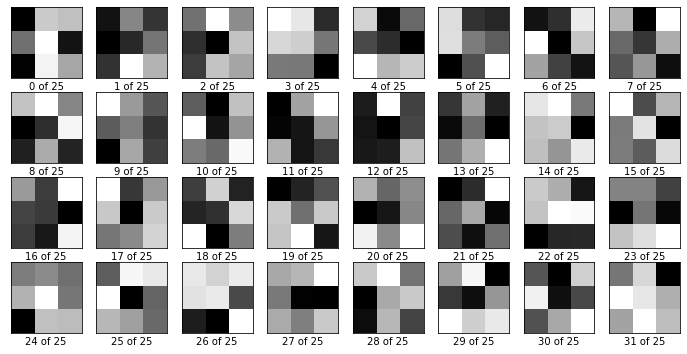

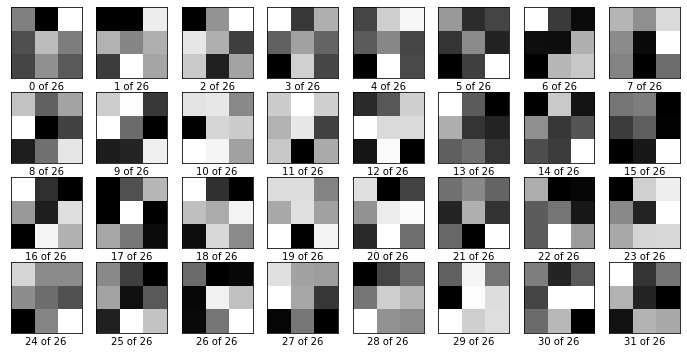

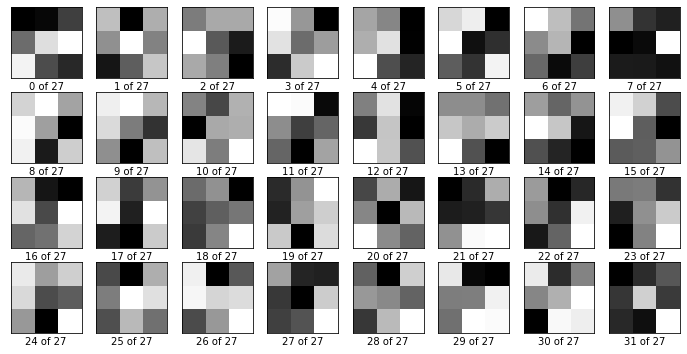

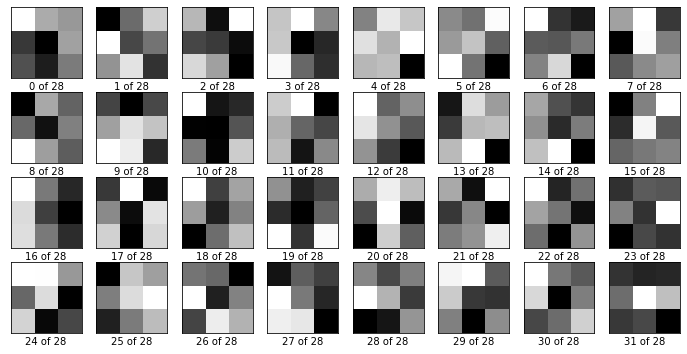

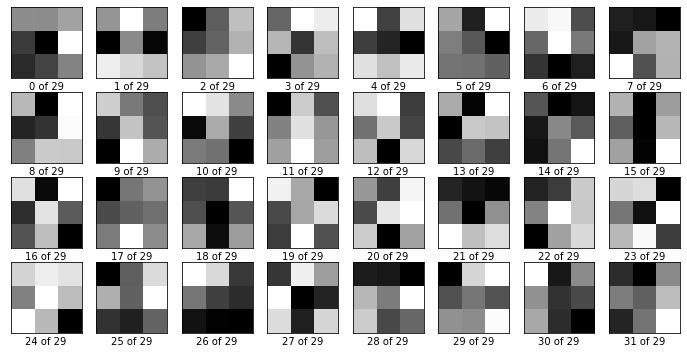

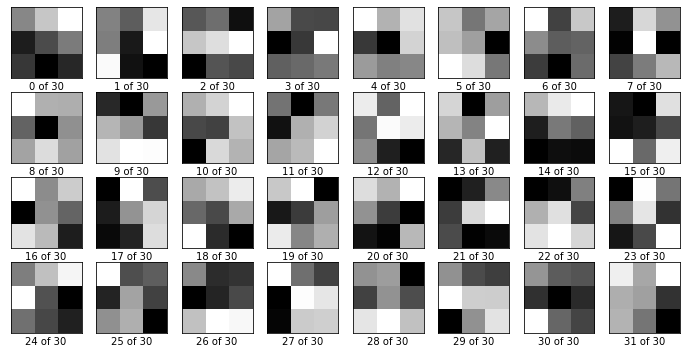

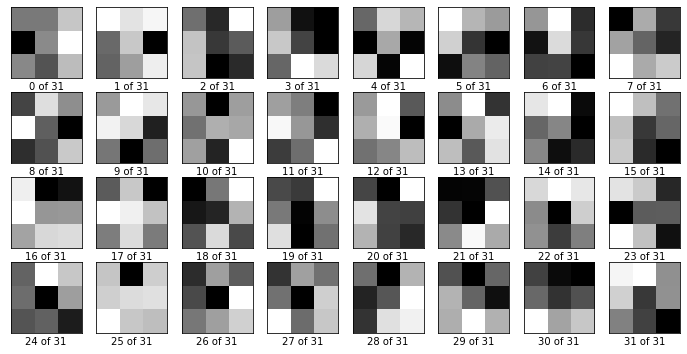

In [23]:
visualize_filter_all(vgg, vgg.layers[2].name)  # Assume we visualize layer 2

Now let us visualize the feature maps before and after training via feeding an image to the network.

Choose an arbitrary image from the training set.

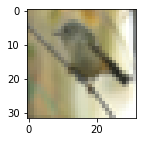

In [24]:
plt.figure(figsize=(2, 2))
plt.imshow(X_train[1])

In [25]:
def visualize_feature_maps(input_img= None, model= None, layer_name= None, n_cols= 8):
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    if len(input_img.shape)==3:
        input_img = tf.expand_dims(input_img, axis =0)
    intermediate_output = intermediate_model.predict(input_img)
    n_feature_maps = intermediate_output.shape[-1]
    n_rows = math.ceil(n_feature_maps/n_cols)
    fig = plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
    plt.axis("off")
    for i in range(n_feature_maps):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(intermediate_output[0,:,:, i], cmap="gray")
        plt.xlabel("{} of {}".format(i, n_feature_maps), fontsize=10)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

Before the training:
Feature maps at the layer conv2d_9 (Layer 2) when feeding an image of 'X_train' to an initialized MiniVGG network.


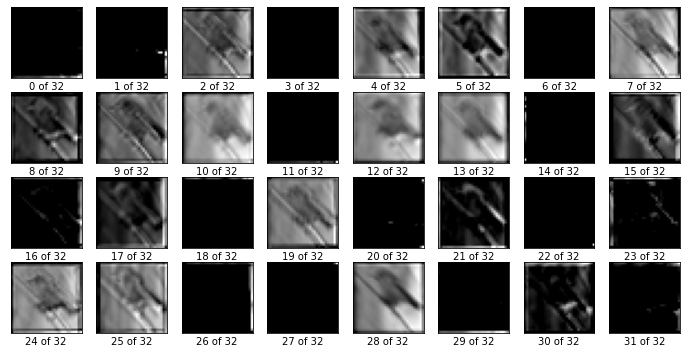

In [26]:
vgg_init = create_vgg()

print("Before the training:")
print("Feature maps at the layer {} (Layer 2) when feeding an image of 'X_train' to an initialized MiniVGG network.".format(vgg_init.layers[2].name))
visualize_feature_maps(X_train[1], vgg_init, vgg_init.layers[2].name)

After the training:
Feature maps at the layer conv2d_5 (Layer 2) when feeding the an image of 'X_train' to the trained MiniVGG network.


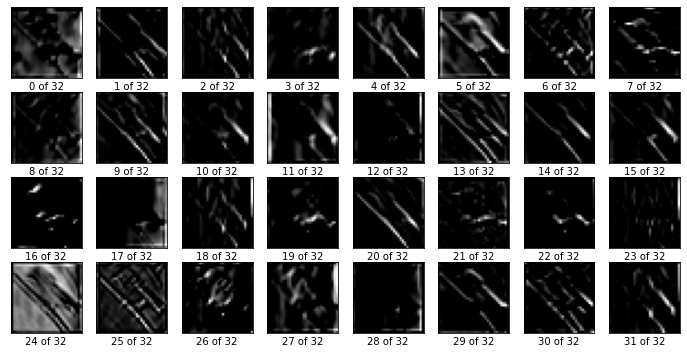

In [27]:
print("After the training:")
print("Feature maps at the layer {} (Layer 2) when feeding the an image of 'X_train' to the trained MiniVGG network.".format(vgg.layers[2].name))
visualize_feature_maps(X_train[1], vgg, vgg.layers[2].name)

**<span style="color:red">Exercise 2</span>:** Choose another arbitrary image and expand the function `visualize_feature_maps` to visualize the original image (as the first image) along with its feature maps as above. The expected results should display (`n_feature_maps` + 1) figures. The caption for the image is its class name (true label).

In [28]:
def visualize_feature_maps(input_img=None, true_label=None, model=None, layer_name=None, n_cols=8):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    if len(input_img.shape)==3:
        batch_input_img = tf.expand_dims(input_img, axis =0)  #make it a 4D tensor with batch_size=1
    intermediate_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    intermediate_output = intermediate_model.predict(batch_input_img)
    n_feature_maps = intermediate_output.shape[-1]
    n_images = math.floor(n_feature_maps) + 1
    n_rows = math.ceil(n_images/n_cols)
    fig = plt.figure(figsize=(n_cols*1.5, n_rows*1.5))
    plt.axis("off")
    for i in range(n_images):
        plt.subplot(n_rows, n_cols, i+1)
        img = input_img if i==0 else intermediate_output[0,:,:, i-1]
        label = "{}".format(class_names[true_label]) if i==0 else "{} of {}".format(i, n_feature_maps)
        if i==0:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap= "gray")
        plt.xlabel(label, fontsize= 10)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

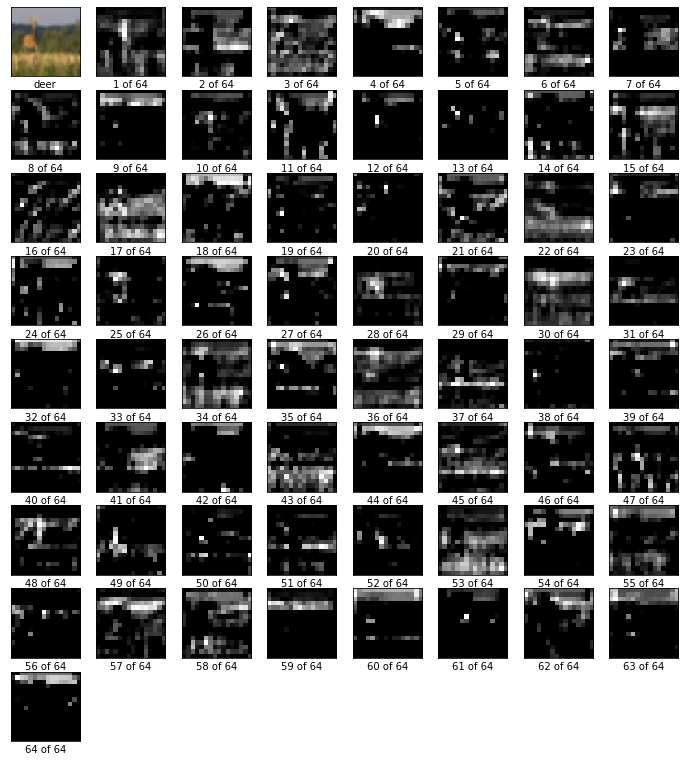

In [29]:
visualize_feature_maps(X_train[0], y_train[0], vgg, vgg.layers[6].name)

**<span style="color:red">Exercise 3</span>:** In the lecture and tutorial of week 7, we will study how to implement SOTA CNN networks for example RESNET, DenseNet and also how to perform transfer learning and fine-tuning a SOTA pretrained CNN to fit a specific and tiny dataset. It is appealing now to investigate what is learned by a SOTA pretrained CNN by visualizing its filters. You will have more sense of why CNNs work well for visual data. Your task is to apply the above code to visualize the filters of a pretrained SOTA CNN. Please use the following code as a good start.

In [30]:
from tensorflow.keras.applications import VGG16

In [31]:
print("Loading network...")
base_model = VGG16(weights="imagenet", include_top=False, input_tensor = layers.Input(shape=(32,32,3)))
print("Showing layers...")
# loop over the layers in the network and display them to the console
for (i, layer) in enumerate(base_model.layers):
    print("Layer {}: {}\t{}".format(i, layer.__class__.__name__, layer.name))

Loading network...
Showing layers...
Layer 0: InputLayer	input_1
Layer 1: Conv2D	block1_conv1
Layer 2: Conv2D	block1_conv2
Layer 3: MaxPooling2D	block1_pool
Layer 4: Conv2D	block2_conv1
Layer 5: Conv2D	block2_conv2
Layer 6: MaxPooling2D	block2_pool
Layer 7: Conv2D	block3_conv1
Layer 8: Conv2D	block3_conv2
Layer 9: Conv2D	block3_conv3
Layer 10: MaxPooling2D	block3_pool
Layer 11: Conv2D	block4_conv1
Layer 12: Conv2D	block4_conv2
Layer 13: Conv2D	block4_conv3
Layer 14: MaxPooling2D	block4_pool
Layer 15: Conv2D	block5_conv1
Layer 16: Conv2D	block5_conv2
Layer 17: Conv2D	block5_conv3
Layer 18: MaxPooling2D	block5_pool


In [35]:
print(base_model.layers[2].weights[0].shape)

(3, 3, 64, 64)


We can visualize a filter using `visualize_filter` or visualize all filters of a convolutional layer using `visualize_filter_all` in the solution of Exercise 1.

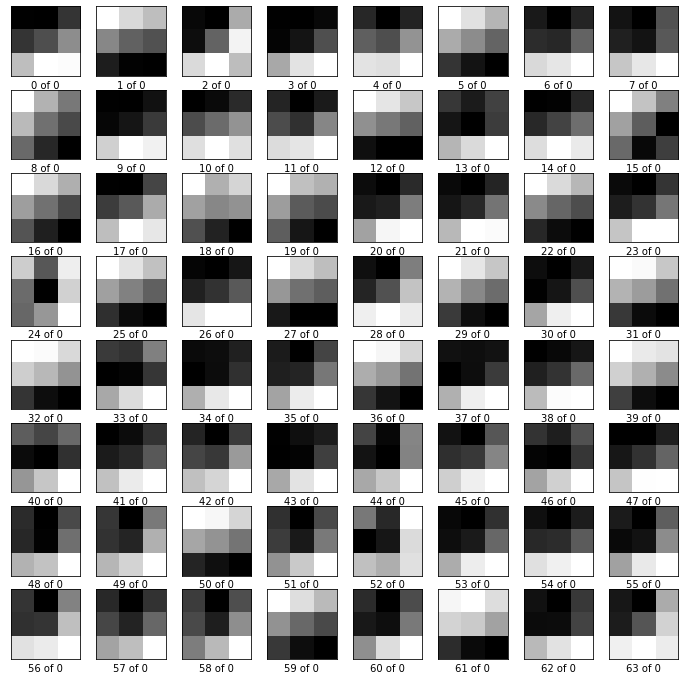

In [33]:
visualize_filter(base_model, 'block1_conv2', filter_index=0)  

---
### <span style="color:#0b486b"> <div  style="text-align:center">**THE END**</div> </span>